

# Risk-oriented, bottom-up modelling of building portfolios with faceted taxonomies 
### Implementation of fuzzy scoring to assign building vulnerability classes starting from faceted taxonomy descriptions. 
#### Massimiliano Pittore, Michael Haas, Konstantinos G. Megalooikonomou and Vitor Silva

 Copyright © GFZ-Potsdam 2018
 
#### Disclaimer: 
 This code is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

The present code is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os, sys
sys.path.append('/Users/pittore/Documents/workspace/RIESGOS/fuzzy_schemas/lib/')
from fuzzy_scoring import fuzzy, scoring


In [12]:
data_path = "../../data"
schema_output_path = "../../schemas"
output_path = "output"

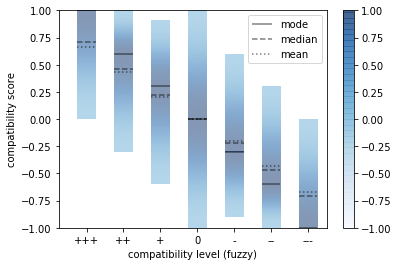

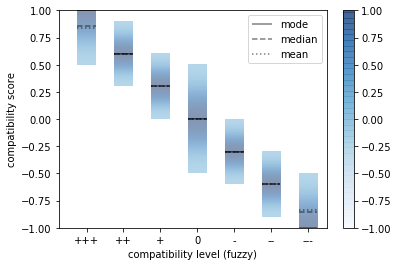

In [3]:

#more uncertain
mf=collections.OrderedDict()
mf['+++'] = [1,0,1]  # highly compatible
mf['++'] = [0.6,-0.3,1]  # moderately compatible
mf['+'] = [0.3,-0.6,0.9] # slightly compatible
mf['0'] = [0,-1,1]  # neutral
mf['-'] =  [-0.3,-0.9,0.6] # slightly incompatible
mf['--'] = [-0.6,-1,0.3]  # moderately incompatible
mf['---'] = [-1,-1,0]   # highly incompatible

#more sharp
mf2=collections.OrderedDict()
mf2['+++'] = [1,0.5,1]  # highly compatible
mf2['++'] = [0.6,0.3,0.9]  # moderately compatible
mf2['+'] = [0.3,0,0.6] # slightly compatible
mf2['0'] = [0,-0.5,0.5]  # neutral
mf2['-'] =  [-0.3,-0.6,0] # slightly incompatible
mf2['--'] = [-0.6,-0.9,-0.3]  # moderately incompatible
mf2['---'] = [-1,-1,-0.5]   # highly incompatible

#plot the two fuzzy compatibility level sets
fuzzy.plot_fnum_vec(mf.values(),mf.keys())
fuzzy.plot_fnum_vec(mf2.values(),mf2.keys())

## Define EMS-98 class definition schema: 

We define here the class definition schema that implements the vulnerability classes described in the EMS-98 original formulation (Grünthal et al.,1998).

| building type | description | GEM tax string         
| :- |:-------------: | :---------------------------------------------------:
|MUR1|rubble stone|MUR+STRUB+MOM/LN/FW+FW1+FWCN
|ADO|adobe/EARTHBRICKS|MUR+ADO+MOM/LN/FW/WWD+FW1+FWCN
|MUR2|simple stone|MUR+ST99+MOL/LN/FW+FW1+FWCN
|MUR3|massive stone|MUR+ST99+STDRE+MOL/LN/FW+FW1+FWCN
|MUR4|unreinforced masonry with manifactured stone units|MUR+ST99+MOCL/LN/FW+FW1+FWCN +EWMA
|MUR5|unreinforced masonry with RC floors|MUR+MO+MOC/LN/FC
|MR|reinforced or confined masonry|MR/MCF/M99+FC+FC2+FWCP
|RC1|reinforced concrete frame without earthquake-resistant design (ERD)|CR+CIP/LN/FC+FC2+FWCP+IRPP/IRVS/IRN/IRIR/HB/IRPS+SOS+YAPP+DNO
|RC2|reinforced concrete frame with moderate earthquake-resistant design (ERD)|CR+CIP/LFM/FC+FC2+FWCP+IRPP/IRVS/IRN/IRIR/HB/IRPS+SOS+YAPP
|RC3|reinforced concrete frame with high level of earthquake-resistant design (ERD)|CR+CIP/LFINF+DUC/FC+FC2+FWCP+IRPP/IRVS/IRN/IRIR/HB/IRPS+SOS+YAPP
|RC4|reinforced concrete walls without ERD|CR+CIP/LWAL+DNO/FC+FC2+FWCP+IRPP/IRVS/IRN/IRIR/HB/IRPS+SOS+YAPP
|RC5|reinforced concrete walls with moderate level of ERD|CR+CIP/LWAL/FC+FC2+FWCP+IRPP/IRVS/IRN/IRIR/HB/IRPS+SOS+YAPP
|RC6|reinforced concrete walls with high level of ERD|CR+CIP/LWAL+DUC/FC+FC2+FWCP+IRPP/IRVS/IRN/IRIR/HB/IRPS+SOS+YAPP
|STEEL|steel structures|S/FME/DUC/LFBR
|WOOD|timber structures|W/FW



In order that the class assignment can be completely reproducible, we also define contextually the set of weights for the attribute types, and the compatibility levels in terms of TFNs.

The definition of this class definition schema is completely independent from a particular set of observations

The class definition schema is then assigned a set of basic metadata and serialized into a simple text file in a format that can be later parsed back. 

sum of values: 1.0
saving fig output/valpo_test_ems98_schema.png


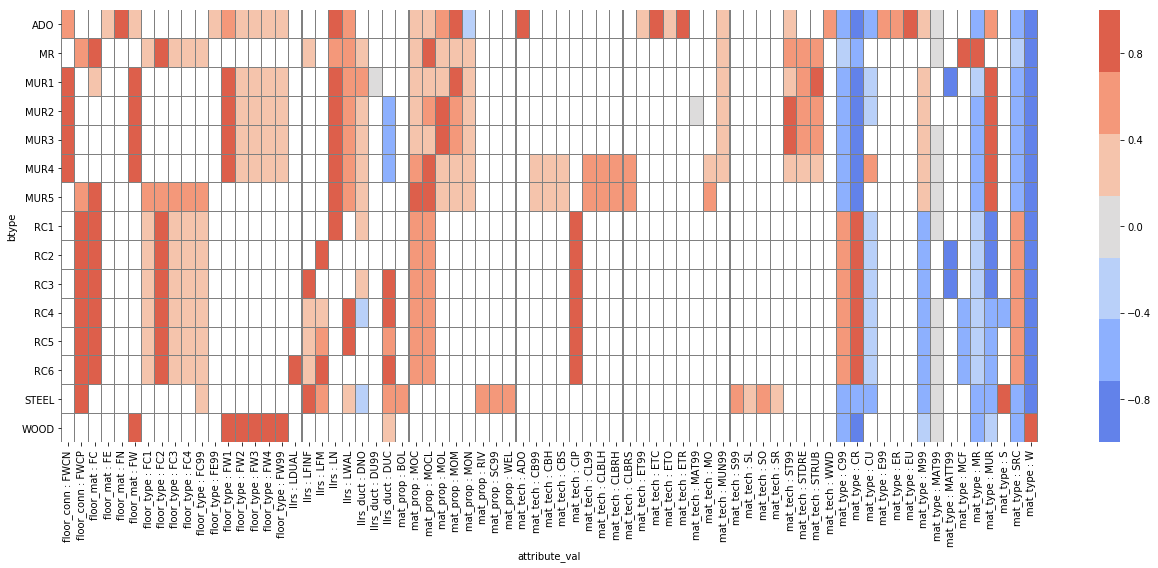

In [9]:
#define the weights 
wgs_ems98 = collections.OrderedDict()

wgs_ems98['mat_type'] = 0.35
wgs_ems98['mat_tech'] = 0.1
wgs_ems98['mat_prop'] = 0.05
wgs_ems98['llrs'] = 0.2
wgs_ems98['llrs_duct'] = 0.1
wgs_ems98['floor_mat'] = 0.1
wgs_ems98['floor_type'] = 0.05
wgs_ems98['floor_conn'] = 0.05

# check if sum of values is "1"
print "sum of values:", sum(wgs_ems98.values())

#define the classes
bmod_schema_ems98 = {
'ADO': 
     {
  'floor_mat': {'FW': '+', 'FE': '+', 'FN': '+++'}, 
  'floor_conn': {'FWCN': '++'}, 
  'mat_prop': {'MON': '-', 'MOM': '+++', 'MOL': '++', 'MOC': '+', 'MOCL': '+'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, #this is from the old one, on what basis does he add this ?
  'llrs_duct': {}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 1}, 
  'floor_type': {'FW4': '+', 'FE99': '+', 'FW99': '+', 'FW3': '+', 'FW1': '++', 'FW2': '+'}, 
  'mat_type': {'M99': '+', 'E99': '++', 'MUR': '++', 'EU': '+++', 'ER': '++',
              'SRC': '--', 'CR': '---', 'CU': '--','C99': '--','MR': '--','W':'---','MAT99':'0'}, 
  'mat_tech': {'ETR': '+++', 'ET99': '+', 'ST99': '+', 'MUN99': '+', 'ETC': '+++', 
               'ADO': '+++','ETO': '+', 'WWD':'++'}, 
     },
    
 'MUR1': 
 {'floor_mat': {'FW': '+++', 'FC':'+'},
  'floor_conn': {'FWCN': '+++'}, 
  'mat_prop': {'MON': '+', 'MOM': '+++', 'MOL': '+', 'MOC': '+', 'MOCL': '+'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, 
  'llrs_duct': {'DNO': '++', 'DU99':'0'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FW4': '+', 'FW99': '+', 'FW3': '+', 'FW1': '+++', 'FW2': '+'}, 
  'mat_type': {'M99': '+', 'MUR': '+++','MR': '-','SRC': '--', 'CR': '---', 'C99': '--',
              'SRC': '--', 'CR': '---', 'C99': '--', 'CU': '-','W':'---','MATT99':'---'}, 
  'mat_tech': {'STDRE': '++', 'ST99': '+', 'STRUB': '+++', 'MUN99': '+'},
 }, 
    
 'MUR2': 
 {'floor_mat': {'FW': '+++'}, 
  'floor_conn': {'FWCN': '+++'}, 
  'mat_prop': {'MON': '+', 'MOM': '++', 'MOL': '+++', 'MOC': '+', 'MOCL': '++'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, 
  'llrs_duct': {'DNO': '+', 'DUC': '--'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FW4': '+', 'FW99': '+', 'FW3': '+', 'FW1': '+++', 'FW2': '+'}, 
  'mat_type': {'M99': '+', 'MUR': '+++','SRC': '--', 'CR': '---', 'C99': '--',
              'SRC': '--', 'CU': '-','MR': '--','W':'---'}, 
  'mat_tech': {'STDRE': '++', 'ST99': '+++', 'STRUB': '++', 'MUN99': '+','MAT99':'0'},
 }, 
    
 'MUR3': 
 {'floor_mat': {'FW': '+++'}, 
  'floor_conn': {'FWCN': '+++'}, 
  'mat_prop': {'MON': '+', 'MOM': '++', 'MOL': '+++', 'MOC': '+', 'MOCL': '+'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, 
  'llrs_duct': {'DNO': '+', 'DUC': '--'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FW4': '+', 'FW99': '+', 'FW3': '+', 'FW1': '+++', 'FW2': '+'}, 
  'mat_type': {'M99': '+', 'MUR': '+++','MR': '--','SRC': '--', 'CR': '---', 'C99': '--','W':'---','MAT99':'0'}, 
  'mat_tech': {'STDRE': '++', 'ST99': '+++', 'STRUB': '++', 'MUN99': '+'},
 },
    
 'MUR4': 
 {'floor_mat': {'FW': '+++'}, 
  'floor_conn': {'FWCN': '+++'}, 
  'mat_prop': {'MON': '+', 'MOM': '+', 'MOL': '+', 'MOC': '++', 'MOCL': '+++'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, 
  'llrs_duct': {'DNO': '+', 'DUC': '--'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FW4': '+', 'FW99': '+', 'FW3': '+', 'FW1': '+++', 'FW2': '+'}, 
  'mat_type': {'M99': '+', 'MUR': '+++','CU': '++','SRC': '--', 'CR': '---',
               'C99': '--','MR': '--','W':'---','MAT99':'0'}, 
  'mat_tech': {'ST99': '+', 'CLBRS': '++', 'CBH': '+', 'CBS': '+', 'CLBLH': '++', 
               'MUN99': '+', 'STDRE': '+', 'CLBRH': '++', 'CB99': '+', 'STRUB': '+','MO': '+','CL99': '++'},
 }, 
    
 'MUR5': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP':'++'}, 
  'mat_prop': {'MON': '+', 'MOM': '+', 'MOL': '+', 'MOC': '+++', 'MOCL': '+++'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, 
  'llrs_duct': {'DNO': '+'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FC1': '++', 'FC2': '++', 'FC3': '++', 'FC4': '++', 'FC99': '++'}, 
  'mat_type': {'M99': '+', 'MUR': '+++','SRC': '--', 'CR': '---', 
               'MR': '--','C99': '--','W':'---','MAT99':'0'}, 
  'mat_tech': {'CLBRS': '++', 'CBH': '+', 'CLBLH': '++','CBS': '+', 
               'CLBRH': '++', 'CB99': '+', 'MO': '++','CL99': '++'},
 }, 
    
    
 'MR':
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP':'++'}, 
  'mat_prop': {'MON': '+', 'MOM': '+', 'MOL': '+', 'MOC': '+', 'MOCL': '+++'}, 
  'llrs': {'LN': '++', 'LWAL': '++', 'LFINF': '+'}, 
  'llrs_duct': {'DNO': '+'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'MCF': '+++', 'MR': '+++','SRC': '-', 'CR': '--', 'C99': '-','W':'---','MAT99':'0'}, 
  'mat_tech': {'STDRE': '++', 'ST99': '++', 'STRUB': '++', 'MUN99': '+'},
 }, 
    
 'RC1': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LN': '+++'}, 
  'llrs_duct': {'DNO': '+'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++','CU': '-',
              'M99': '--', 'MUR': '---','MR': '-','W':'---','MAT99':'0'}, 
  'mat_tech': {'CIP': '+++'},
 }, 
    
 'RC2': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LFM': '+++'}, 
  'llrs_duct': {}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++','CU': '-',
              'M99': '--', 'MUR': '---','MR': '-','W':'---','MATT99':'---'}, 
  'mat_tech': {'CIP': '+++'},

 }, 
    
 'RC3': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LFINF': '+++'}, 
  'llrs_duct': {'DNO': '+', 'DUC': '+++'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++', 'CU': '-',
              'M99': '--', 'MUR': '---','MR': '-','W':'---','MATT99':'---'}, 
  'mat_tech': {'CIP': '+++'},
 },
    
 'RC4': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LFM': '+', 'LWAL': '+++', 'LFINF': '+'}, 
  'llrs_duct': {'DNO': '-', 'DUC': '+++'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++', 'CU': '-', 'S': '--',
              'M99': '--', 'MR': '-','MCF': '--','MUR': '--','W':'---','MAT99':'0'}, 
  'mat_tech': {'CIP': '+++'},
 }, 

    
 'RC5': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LFM': '++', 'LWAL': '+++', 'LFINF': '+'}, 
  'llrs_duct': {'DUC': '++'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++','CU': '-',
              'M99': '--', 'MR': '-','MCF': '--','MUR': '--','W':'---','MAT99':'0'}, 
  'mat_tech': {'CIP': '+++'},
 }, 
    
 'RC6': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LFM': '+++', 'LDUAL': '+++', 'LFINF': '+'}, 
  'llrs_duct': {'DUC': '+++'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++', 'CU': '-',
              'M99': '--', 'MR': '-','MCF': '--','MUR': '--','W':'---','MAT99':'0'}, 
  'mat_tech': {'CIP': '+++'},
 }, 
    
 'WOOD': 
 {'floor_mat': {'FW': '+++'}, 
  'floor_conn': {}, 
  'mat_prop': {}, 
  'llrs': {}, 
  'llrs_duct': {'DUC': '+'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FW4': '+++', 'FW99': '+++', 'FW3': '+++', 'FW1': '+++', 'FW2': '+++'}, 
  'mat_type': {'W': '+++','SRC': '--', 'CR': '---', 'C99': '--',
              'M99': '-', 'MUR': '-','MR': '--','MAT99':'0'}, 
  'mat_tech': {},
 }, 
    
'STEEL': 
 {'floor_mat': {}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'SC99': '++', 'BOL': '++', 'RIV': '++', 'WEL': '++'}, 
  'llrs': {'LFM': '++', 'LWAL': '+', 'LFINF': '+++'}, 
  'llrs_duct': {'DUC': '++','DNO': '-'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
  'floor_type': {'FC99': '+'}, 
  'mat_type': {'S': '+++','CR': '--','SRC': '--','C99': '--','CU': '--',
               'M99': '--','MUR': '--','MR': '--','W':'---','MAT99':'0'}, 
  'mat_tech': {'SO': '++', 'SL': '+', 'SR': '+', 'S99': '++'},
 }
}

#fuzzy compatibility values #THIS SHOULD  NOT BE CHANGED!!!!
fuzComp_ems98=collections.OrderedDict()
fuzComp_ems98['---']= [-1, -1, 0] 
fuzComp_ems98['--']= [-0.6, -1, 0.3]
fuzComp_ems98['-']= [-0.3, -0.9, 0.6]
fuzComp_ems98['0']= [0, -1, 1]
fuzComp_ems98['+']= [0.3, -0.6, 0.9]
fuzComp_ems98['++']= [0.6, -0.3, 1]
fuzComp_ems98['+++']= [1, 0, 1]

#set the metadata to serialize the class definition schema
bmod_ems98_meta = collections.OrderedDict()
bmod_ems98_meta['name'] = 'bmod_ems98'
bmod_ems98_meta['description'] = 'definition of EMS-98 building types, using fuzzy compatibility formulation'
bmod_ems98_meta['version'] = '1.0'
bmod_ems98_meta['classes'] = bmod_schema_ems98.keys()
bmod_ems98_meta['weights'] = wgs_ems98
bmod_ems98_meta['fuzzy_values'] = fuzComp_ems98
bmod_ems98_meta['definition']= bmod_schema_ems98

#NOTE: we use ordered dicts but the order is not guaranteed
#      when loading the structure from a json / yaml file

#save file ? 
outf_ems98 = os.path.join(schema_output_path,'valpo_test_ems98.json')
scoring.exportClassDict(bmod_ems98_meta,outf_ems98,output_format='json')

#plot schema
outplot_ems98 = os.path.join(output_path,'valpo_test_ems98_schema.png')
scoring.plot_bclass_schema(bmod_schema_ems98,wgs_ems98,fuzComp_ems98,outplot)

Define HAZUS class definition schema:
We define here the class definition schema that implements the vulnerability classes described in the HAZUS original formulation.

building type	description	GEM tax string


In order that the class assignment can be completely reproducible, we also define contextually the set of weights for the attribute types, and the compatibility levels in terms of TFNs.

The definition of this class definition schema is completely independent from a particular set of observations

The class definition schema is then assigned a set of basic metadata and serialized into a simple text file in a format that can be later parsed back.

sum of values: 1.0
saving fig output/valpo_test_hazus_schema.png


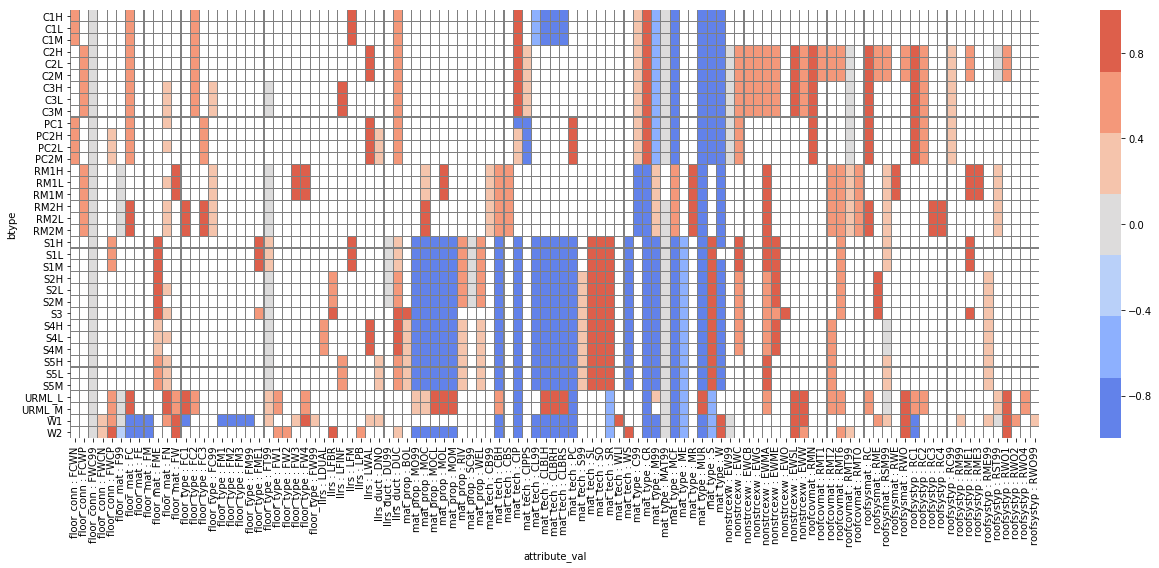

In [10]:
## EARTHQUAKES
## BUILDING CLASS
## HAZUS 

#define the weights 

#occupancy can be added as per the data, considering if data is avalable. 
wgs_HAZUS = collections.OrderedDict()
wgs_HAZUS['mat_type'] = 0.25  
wgs_HAZUS['mat_tech'] = 0.1 
wgs_HAZUS['mat_prop'] = 0.05  
wgs_HAZUS['llrs'] = 0.2 #resists lateral load,
wgs_HAZUS['llrs_duct'] = 0.1 
wgs_HAZUS['floor_mat'] = 0.05 
wgs_HAZUS['floor_type'] = 0.05
wgs_HAZUS['floor_conn'] = 0.01 
wgs_HAZUS['nonstrcexw'] = 0.1  
#wgs_HAZUS['roof_shape'] = 0.1 
wgs_HAZUS['roofcovmat'] = 0.05 
wgs_HAZUS['roofsysmat'] = 0.02
wgs_HAZUS['roofsystyp'] = 0.02



# check if sum of values is "1"
print "sum of values:", sum(wgs_HAZUS.values())

#define the classes
bmod_schema_HAZUS = {  
    
    'W1': 
    
 {'mat_type': {'W': '+++','M99':'---', 'CR':'---', 'S':'--','ME':'--','MUR':'---','MAT99':'0','MCF':'---'}, 
  'mat_tech': {'CL99':'---','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','SR':'--','CBH':'---','WLI':'+++'},
  'mat_prop': {},  
  'llrs': {'LWAL':'+'}, 
  'llrs_duct': {'DNO':'+'}, 
  'floor_mat': {'FC':'---','FM':'---','FE':'---','F99':'0','FW':'+++','FN':'++'},
  'floor_type': {'FM99':'---','FM1':'---','FM2':'---','FM3':'---','FT99':'+','FC1':'---','FW99':'+','FW3':'+','FW4':'+++'},
  'floor_conn': {'FWCN':'+','FWCP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EWSL':'+++','EWW':'+++','EW99':'0'},
  'roof_shape':{}, 
  'roofcovmat':{},
  'roofsysmat':{'RWO':'+++','RME':'++','RSM99':'+'},
  'roofsystyp':{'RWO1':'+++','RM99':'+','RC1':'---','RME99':'+','RST99':'0','RWO2':'++','RWO99':'+'},
  'height_1': {'H_MIN': 1, 'H_MAX': 2}, #GIVEN BY HAZUS
 },
    
         'W2': 
    
 {'mat_type': {'W': '+++','M99':'---', 'CR':'---', 'S':'--','ME':'--','MUR':'---','MAT99':'0','MCF':'---'}, 
  'mat_tech': {'CL99':'---','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','SR':'--','CBH':'---','WS':'+++'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---'},  
  'llrs': {'LFBR':'+++','LPB':'++'}, 
  'llrs_duct': {'DUC':'+'}, 
  'floor_mat': {'FC':'---','FM':'---','FE':'---','F99':'-','FW':'+++'},
  'floor_type': {'FW1':'++','FW2':'++'},
  'floor_conn': {'FWCN':'+','FWCP':'+++','FWC99':'0'}, 
  'nonstrcexw':{'EW99':'0','EWW':'++','EWSL':'+++'},
  'roof_shape':{}, 
  'roofcovmat':{'RMT6':'++','RMT99':'+'},
  'roofsysmat':{'RWO':'+++'},
  'roofsystyp':{'RWO1':'+++','RC1':'---'},#TAKEN FROM DATA
  'height_1': {'H_MIN': 1, 'H_MAX': 2}, #GIVEN BY HAZUS
 },
    
             'S1L': 
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','SC99':'0','WEL':'++','RIV':'++'},  
  'llrs': {'LFM':'+++'}, 
  'llrs_duct': {'DUC':'+','DU99':'0'}, 
  'floor_mat': {'FME':'+++'},
  'floor_type': {'FT99':'+','FME1':'+++'},
  'floor_conn': {'FWC99':'0','FWCP':'++'}, 
  'nonstrcexw':{'EWME':'+++','EWC':'+++','EWMA':'+++'},
  'roof_shape':{},  #TAKEN FROM DATA
  'roofcovmat':{'RMT6':'++'},#TAKEN FROM DATA
  'roofsysmat':{'RSM99':'+'},#TAKEN FROM DATA
  'roofsystyp':{'RME1':'+++'},#TAKEN FROM DATA
  'height_1': {'H_MIN': 1, 'H_MAX': 3}, #HAZUS DIVIDES S1 INTO S1L,S1M,S1H DEPENDING ON HEIGHT  
 },
   
             'S1M': 
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','SC99':'0','WEL':'++','RIV':'++'},  
  'llrs': {'LFM':'+++'}, 
  'llrs_duct': {'DUC':'+','DU99':'0'}, 
  'floor_mat': {'FME':'+++'},
  'floor_type': {'FT99':'+','FME1':'+++'},
  'floor_conn': {'FWC99':'0','FWCP':'++'}, 
  'nonstrcexw':{'EWME':'+++','EWC':'+++','EWMA':'+++'},
  'roof_shape':{},#TAKEN FROM DATA
  'roofcovmat':{'RMT6':'++'},#TAKEN FROM DATA
  'roofsysmat':{'RSM99':'+'},#TAKEN FROM DATA
  'roofsystyp':{'RME1':'+++'},#TAKEN FROM DATA
  'height_1': {'H_MIN': 4, 'H_MAX': 7}, #HAZUS DIVIDES S1 INTO S1L,S1M,S1H DEPENDING ON HEIGHT  
 },
   
    
             'S1H': 
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','SC99':'0','WEL':'++','RIV':'++'},  
  'llrs': {'LFM':'+++'}, 
  'llrs_duct': {'DUC':'+','DU99':'0'}, 
  'floor_mat': {'FME':'+++'},
  'floor_type': {'FT99':'+','FME1':'+++'},
  'floor_conn': {'FWC99':'0','FWCP':'++'}, 
  'nonstrcexw':{'EWME':'+++','EWC':'+++','EWMA':'+++'},
  'roof_shape':{},  #TAKEN FROM DATA
  'roofcovmat':{'RMT6':'++'},#TAKEN FROM DATA
  'roofsysmat':{'RSM99':'+'},#TAKEN FROM DATA
  'roofsystyp':{'RME1':'+++'},#TAKEN FROM DATA
  'height_1': {'H_MIN': 8, 'H_MAX': 99}, #HAZUS DIVIDES S1 INTO S1L,S1M,S1H DEPENDING ON HEIGHT  
 },
   
             'S2L': 
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','S99':'+','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','SC99':'0','WEL':'++','RIV':'++'},  
  'llrs': {'LFBR':'++'}, 
  'llrs_duct': {'DUC':'++','DU99':'0'}, 
  'floor_mat': {'FME':'+++','FN':'+'},#PARTIALLY TAKEN FROM DATA
  'floor_type': {'FT99':'0'},
  'floor_conn': {'FWC99':'0'}, 
  'nonstrcexw':{'EWME':'+++','EWC':'++','EWMA':'++'},
  'roof_shape':{}, #TAKEN FROM DATA
  'roofcovmat':{'RMT6':'++'},#TAKEN FROM DATA
  'roofsysmat':{'RME':'+++'},#TAKEN FROM DATA
  'roofsystyp':{'RME99':'+'},#TAKEN FROM DATA
  'height_1': {'H_MIN': 1, 'H_MAX': 3}, 
 },
    
    'S2M': 
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','S99':'+','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','SC99':'0','WEL':'++','RIV':'++'},  
  'llrs': {'LFBR':'++'}, 
  'llrs_duct': {'DUC':'++','DU99':'0'}, 
  'floor_mat': {'FME':'+++'},#PARTIALLY TAKEN FROM DATA
  'floor_type': {'FT99':'0'},
  'floor_conn': {'FWC99':'0'}, 
  'nonstrcexw':{'EWME':'+++','EWC':'++','EWMA':'++'},
  'roof_shape':{}, #TAKEN FROM DATA
  'roofcovmat':{'RMT6':'++'},#TAKEN FROM DATA
  'roofsysmat':{'RME':'+++'},#TAKEN FROM DATA
  'roofsystyp':{'RME99':'+'},#TAKEN FROM DATA
  'height_1': {'H_MIN': 4, 'H_MAX': 7}, 
 },
    
    'S2H': 
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','S99':'+','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','SC99':'0','WEL':'++','RIV':'++'},  
  'llrs': {'LFBR':'++'}, 
  'llrs_duct': {'DUC':'++','DU99':'0'}, 
  'floor_mat': {'FME':'+++'},#PARTIALLY TAKEN FROM DATA
  'floor_type': {'FT99':'0'},
  'floor_conn': {'FWC99':'0'}, 
  'nonstrcexw':{'EWME':'+++','EWC':'++','EWMA':'++'},
  'roof_shape':{}, #TAKEN FROM DATA
  'roofcovmat':{'RMT6':'++'},#TAKEN FROM DATA
  'roofsysmat':{'RME':'+++'},#TAKEN FROM DATA
  'roofsystyp':{'RME99':'+'},#TAKEN FROM DATA
  'height_1': {'H_MIN': 8, 'H_MAX': 99}, 
 },
     'S3': 
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','S99':'+','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','BOL':'+++'},  
  'llrs': {'LFBR':'+++'}, 
  'llrs_duct': {'DUC':'+++'}, 
  'floor_mat': {'FME':'+++','FN':'+'},
  'floor_type': {'FT99':'0','FME1':'++'},#TAKEN FROM DATA
  'floor_conn': {'FWC99':'0'},#TAKEN FROM DATA
  'nonstrcexw':{'EWME':'++','EWC':'++','EWMA':'++','EWO':'+++'},
  'roof_shape':{}, 
  'roofcovmat':{'RMT6':'++'},
  'roofsysmat':{'RME':'+++'},
  'roofsystyp':{'RME99':'+','RME1':'+++'},
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
 },
    
    'S4L': 
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','S99':'+','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','BOL':'+','WEL':'+','RIV':'+'},  
  'llrs': {'LWAL':'+++','LDUAL':'++'}, 
  'llrs_duct': {'DUC':'+++'}, 
  'floor_mat': {'FN':'+','FME':'+'}, #HAZUS SAYS ANY TYPE PF FLOORING
  'floor_type': {'FT99':'0'},#TAKEN FROM DATA
  'floor_conn': {'FWC99':'0'}, #TAKEN FROM DATA
  'nonstrcexw':{'EWME':'+++','EWC':'++','EWMA':'++'},
  'roof_shape':{},  #TAKEN FROM DATA
  'roofcovmat':{'RMT2':'++'},#TAKEN FROM DATA
  'roofsysmat':{'RSM99':'0'},#TAKEN FROM DATA
  'roofsystyp':{'RME99':'+'},#TAKEN FROM DATA
  'height_1': {'H_MIN': 1, 'H_MAX': 3}, 
 },
    
        'S4M': 
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','S99':'+','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','BOL':'+','WEL':'+','RIV':'+'},  
  'llrs': {'LWAL':'+++','LDUAL':'++'}, 
  'llrs_duct': {'DUC':'+++'}, 
  'floor_mat': {'FME':'+'}, #HAZUS SAYS ANY TYPE PF FLOORING
  'floor_type': {'FT99':'0'},#TAKEN FROM DATA
  'floor_conn': {'FWC99':'0'}, #TAKEN FROM DATA
  'nonstrcexw':{'EWME':'+++','EWC':'++','EWMA':'++'}, #SHEAR WALLS MADE OF RC
  'roof_shape':{},  #TAKEN FROM DATA
  'roofcovmat':{'RMT2':'++'},#TAKEN FROM DATA
  'roofsysmat':{'RSM99':'0'},#TAKEN FROM DATA
  'roofsystyp':{'RME99':'+'},#TAKEN FROM DATA
  'height_1': {'H_MIN': 4, 'H_MAX': 7}, 
 },
    
    'S4H': 
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','S99':'+','CLBRS':'---','CLBRH':'---','CLBLH':'---', 'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','BOL':'+','WEL':'+','RIV':'+'},  
  'llrs': {'LWAL':'+++','LDUAL':'++'}, 
  'llrs_duct': {'DUC':'+++'}, 
  'floor_mat': {'FME':'+'}, #HAZUS SAYS ANY TYPE PF FLOORING
  'floor_type': {'FT99':'0'},#TAKEN FROM DATA
  'floor_conn': {'FWC99':'0'}, #TAKEN FROM DATA
  'nonstrcexw':{'EWME':'+++','EWC':'++','EWMA':'++'},
  'roof_shape':{},  #TAKEN FROM DATA
  'roofcovmat':{'RMT2':'++'},#TAKEN FROM DATA
  'roofsysmat':{'RSM99':'0'},#TAKEN FROM DATA
  'roofsystyp':{'RME99':'+'},#TAKEN FROM DATA
  'height_1': {'H_MIN': 8, 'H_MAX': 99}, 
 },
   
    
      'S5L': ##NOT PRESENT IN VALPARAISO DATA
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','S99':'+','CLBRS':'---','CLBRH':'---','CLBLH':'---', 
               'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','WEL':'+','RIV':'+','BOL':'+'},
  'llrs': {'LFINF':'++'},
  'llrs_duct': {'DUC':'++','DNO':'+'}, 
 'floor_mat': {'FN':'+','FME':'++'},
  'floor_type': {'FT99':'0'},
  'floor_conn': {'FWC99':'0'}, 
  'nonstrcexw':{'EWMA':'+++'},
  'roof_shape':{},  
  'roofcovmat':{'RMT2':'++'},
 'roofsysmat':{'RSM99':'+'},
 'roofsystyp':{'RME99':'+'},
  'height_1': {'H_MIN': 1, 'H_MAX': 3}, 
 },
    
          'S5M': ##NOT PRESENT IN VALPARAISO DATA
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','S99':'+','CLBRS':'---','CLBRH':'---','CLBLH':'---', 
               'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','WEL':'+','RIV':'+','BOL':'+'},
  'llrs': {'LFINF':'++'},
  'llrs_duct': {'DUC':'++','DNO':'+'}, 
 'floor_mat': {'FN':'+','FME':'++'},
  'floor_type': {'FT99':'0'},
  'floor_conn': {'FWC99':'0'}, 
  'nonstrcexw':{'EWMA':'+++'},
  'roof_shape':{},  
  'roofcovmat':{'RMT2':'++'},
 'roofsysmat':{'RSM99':'+'},
 'roofsystyp':{'RME99':'+'},
  'height_1': {'H_MIN': 4, 'H_MAX': 7}, 
 },
    
          'S5H': ##NOT PRESENT IN VALPARAISO DATA
    
 {'mat_type': {'S': '+++','M99':'---', 'CR':'---','ME':'--','MUR':'---','MAT99':'0','W':'---','MCF':'---'}, 
  'mat_tech': {'SL':'+++','SR':'+++','SO':'+++','CL99':'---','S99':'+','CLBRS':'---','CLBRH':'---','CLBLH':'---', 
               'CIP':'---','PC':'---','CBH':'---','WS':'---'},
  'mat_prop': {'MO99':'---','MOM':'---','MOL':'---','MOCL':'---','MOC':'---','WEL':'+','RIV':'+','BOL':'+'},
  'llrs': {'LFINF':'++'},
  'llrs_duct': {'DUC':'++','DNO':'+'}, 
 'floor_mat': {'FN':'+','FME':'++'},
  'floor_type': {'FT99':'0'},
  'floor_conn': {'FWC99':'0'}, 
  'nonstrcexw':{'EWMA':'+++'},
  'roof_shape':{},  
  'roofcovmat':{'RMT2':'++'},
 'roofsysmat':{'RSM99':'+'},
 'roofsystyp':{'RME99':'+'},
  'height_1': {'H_MIN': 8, 'H_MAX': 99}, 
 },
    
     'C1L': ## NOT PRESENT IN THE VALPARAISO DATA
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+++','CL99':'--','CLBRS':'---','CLBRH':'---','CLBLH':'---'},
  'mat_prop': {},  
  'llrs': {'LFM':'+++'}, 
  'llrs_duct': {'DUC':'++'}, 
  'floor_mat': {'FC':'++'},
  'floor_type': {'FC2':'++'},
  'floor_conn': {'FCWN':'++','FWC99':'0'}, 
  'nonstrcexw':{},
  'roof_shape':{},  
  'roofcovmat':{},
   'roofsysmat':{},
  'roofsystyp':{},
  'height_1': {'H_MIN': 1, 'H_MAX': 3}, 
},
 
    'C1M': ## NOT PRESENT IN THE VALPARAISO DATA
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+++','CL99':'--','CLBRS':'---','CLBRH':'---','CLBLH':'---'},
  'mat_prop': {},  
  'llrs': {'LFM':'+++'}, 
  'llrs_duct': {'DUC':'++'}, 
  'floor_mat': {'FC':'++'},
  'floor_type': {'FC2':'++'},
  'floor_conn': {'FCWN':'++','FWC99':'0'}, 
  'nonstrcexw':{},
  'roof_shape':{},  
  'roofcovmat':{},
   'roofsysmat':{},
  'roofsystyp':{},
  'height_1': {'H_MIN': 4, 'H_MAX': 7}, 
},
 
     'C1H': ## NOT PRESENT IN THE VALPARAISO DATA
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+++','CL99':'--','CLBRS':'---','CLBRH':'---','CLBLH':'---'},
  'mat_prop': {},  
  'llrs': {'LFM':'+++'}, 
  'llrs_duct': {'DUC':'++'}, 
  'floor_mat': {'FC':'++'},
  'floor_type': {'FC2':'++'},
  'floor_conn': {'FCWN':'++','FWC99':'0'}, 
  'nonstrcexw':{},
  'roof_shape':{},  
  'roofcovmat':{},
   'roofsysmat':{},
  'roofsystyp':{},
  'height_1': {'H_MIN': 8, 'H_MAX': 99}, 
},
      
    'C2L': 
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+++','CIPPS':'+'},
  'mat_prop': {},  
  'llrs': {'LWAL':'+++'}, 
  'llrs_duct': {'DUC':'++'}, 
  'floor_mat': {'FC':'++'},
  'floor_type': {'FC2':'++'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EW99':'0','EWC':'++','EWCB':'++','EWG':'++','EWMA':'++','EWME':'++','EWSL':'+++','EWW':'++'}, #TAKEN FROM DATA
  'roof_shape':{}, #TAKEN FROM DATA 
  'roofcovmat':{'RMN':'+++','RMT1':'++','RMT2':'++','RMT6':'++','RMT99':'0'},
   'roofsysmat':{'RC':'+++','RME':'++','RSM99':'++','RWO':'++'},
  'roofsystyp':{'RC1':'+++','RC2':'++','RC99':'+','RME1':'++','RST99':'0','RWO1':'++'},
  'height_1': {'H_MIN': 1, 'H_MAX': 3}, 
 },
  
     'C2M': 
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+++','CIPPS':'+'},
  'mat_prop': {},  
  'llrs': {'LWAL':'+++'}, 
  'llrs_duct': {'DUC':'++'}, 
  'floor_mat': {'FC':'++'},
  'floor_type': {'FC2':'++'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EW99':'0','EWC':'++','EWCB':'++','EWG':'++','EWMA':'++','EWME':'++','EWSL':'+++','EWW':'++'}, #TAKEN FROM DATA
  'roof_shape':{}, #TAKEN FROM DATA 
  'roofcovmat':{'RMN':'+++','RMT1':'++','RMT2':'++','RMT6':'++','RMT99':'0'},
   'roofsysmat':{'RC':'+++','RME':'++','RSM99':'++','RWO':'++'},
  'roofsystyp':{'RC1':'+++','RC2':'++','RC99':'+','RME1':'++','RST99':'0','RWO1':'++'},
  'height_1': {'H_MIN': 4, 'H_MAX': 7}, 
 },
    
         'C2H': 
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+++','CIPPS':'+'},
  'mat_prop': {},  
  'llrs': {'LWAL':'+++'}, 
  'llrs_duct': {'DUC':'++'}, 
  'floor_mat': {'FC':'++'},
  'floor_type': {'FC2':'++'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EW99':'0','EWC':'++','EWCB':'++','EWG':'++','EWMA':'++','EWME':'++','EWSL':'+++','EWW':'++'}, #TAKEN FROM DATA
  'roof_shape':{}, #TAKEN FROM DATA 
  'roofcovmat':{'RMN':'+++','RMT1':'++','RMT2':'++','RMT6':'++','RMT99':'0'},
   'roofsysmat':{'RC':'+++','RME':'++','RSM99':'++','RWO':'++'},
  'roofsystyp':{'RC1':'+++','RC2':'++','RC99':'+','RME1':'++','RST99':'0','RWO1':'++'},
  'height_1': {'H_MIN': 8, 'H_MAX': 99}, 
 },
    
    
         'C3L': 
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+++','CIPPS':'+'},
  'mat_prop': {},  
  'llrs': {'LFINF':'+++'}, 
  'llrs_duct': {'DUC':'++'}, 
  'floor_mat': {'FC':'++','FN':'+'},
  'floor_type': {'FC2':'++','FC99':'+','FT99':'0'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EW99':'0','EWC':'++','EWCB':'++','EWG':'++','EWMA':'++','EWME':'++','EWSL':'+++','EWW':'++'}, #TAKEN FROM DATA
  'roof_shape':{}, #TAKEN FROM DATA 
  'roofcovmat':{'RMN':'+++','RMT99':'0'},
   'roofsysmat':{'RC':'+++'},
  'roofsystyp':{'RC1':'+++','RC2':'++','RC99':'+'},
  'height_1': {'H_MIN': 1, 'H_MAX': 3}, 
 },
    
         'C3M': 
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+++','CIPPS':'+'},
  'mat_prop': {},  
  'llrs': {'LFINF':'+++'}, 
  'llrs_duct': {'DUC':'++'}, 
  'floor_mat': {'FC':'++','FN':'+'},
  'floor_type': {'FC2':'++','FC99':'+','FT99':'0'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EW99':'0','EWC':'++','EWCB':'++','EWG':'++','EWMA':'++','EWME':'++','EWSL':'+++','EWW':'++'}, #TAKEN FROM DATA
  'roof_shape':{}, #TAKEN FROM DATA 
  'roofcovmat':{'RMN':'+++','RMT99':'0'},
   'roofsysmat':{'RC':'+++'},
  'roofsystyp':{'RC1':'+++','RC2':'++','RC99':'+'},
  'height_1': {'H_MIN': 4, 'H_MAX': 7}, 
 },
    
     'C3H': 
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+++','CIPPS':'+'},
  'mat_prop': {},  
  'llrs': {'LFINF':'+++'}, 
  'llrs_duct': {'DUC':'++'}, 
  'floor_mat': {'FC':'++','FN':'+'},
  'floor_type': {'FC2':'++','FC99':'+','FT99':'0'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EW99':'0','EWC':'++','EWCB':'++','EWG':'++','EWMA':'++','EWME':'++','EWSL':'+++','EWW':'++'}, #TAKEN FROM DATA
  'roof_shape':{}, #TAKEN FROM DATA 
  'roofcovmat':{'RMN':'+++','RMT99':'0'},
   'roofsysmat':{'RC':'+++'},
  'roofsystyp':{'RC1':'+++','RC2':'++','RC99':'+'},
  'height_1': {'H_MIN': 8, 'H_MAX': 99}, 
 },
         'PC1': #NOT IN VALPARAISO DATA
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'---','CIPPS':'---','PC':'+++'},
  'mat_prop': {},  
  'llrs': {'LWAL':'+++'}, 
  'llrs_duct': {'DUC':'++'}, 
  'floor_mat': {'FC':'++','FN':'+'},
  'floor_type': {'FC3':'++'},
  'floor_conn': {'FCWN':'++','FWC99':'0'}, 
  'nonstrcexw':{'EW99':'0','EWC':'++'}, 
  'roof_shape':{},  
  'roofcovmat':{'RMN':'+++','RMT99':'0'},
   'roofsysmat':{'RC':'+++'},
  'roofsystyp':{'RC1':'+++','RC2':'++','RC99':'+'},
  'height_1': {'H_MIN': 1, 'H_MAX': 99}, 
 },
    
             'PC2L': #NOT IN VALPARAISO DATA
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+','CIPPS':'---','PC':'+++'},
  'mat_prop': {},  
  'llrs': {'LWAL':'+++'}, 
  'llrs_duct': {'DUC':'++','DNO':'+'}, 
  'floor_mat': {'FC':'++','FN':'+'},
  'floor_type': {'FC3':'++'},
  'floor_conn': {'FCWN':'++','FWC99':'0','FWCP':'+'}, 
  'nonstrcexw':{'EW99':'0','EWC':'++'}, 
  'roof_shape':{},  
  'roofcovmat':{'RMN':'+++','RMT99':'0'},
   'roofsysmat':{'RC':'+++'},
  'roofsystyp':{'RC1':'+++','RC2':'++','RC99':'+'},
  'height_1': {'H_MIN': 1, 'H_MAX': 3}, 
 },
    'PC2M': #NOT IN VALPARAISO DATA
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+','CIPPS':'---','PC':'+++'},
  'mat_prop': {},  
  'llrs': {'LWAL':'+++'}, 
  'llrs_duct': {'DUC':'++','DNO':'+'}, 
  'floor_mat': {'FC':'++'},
  'floor_type': {'FC3':'++'},
  'floor_conn': {'FCWN':'++','FWC99':'0','FWCP':'+'}, 
  'nonstrcexw':{'EW99':'0','EWC':'++'}, 
  'roof_shape':{},  
  'roofcovmat':{'RMN':'+++','RMT99':'0'},
   'roofsysmat':{'RC':'+++'},
  'roofsystyp':{'RC1':'+++','RC2':'++','RC99':'+'},
  'height_1': {'H_MIN': 4, 'H_MAX': 7}, 
 },
    
    'PC2H': #NOT IN VALPARAISO DATA
    
 {'mat_type': {'CR': '+++', 'C99':'+','MUR': '---','M99':'--','W':'---','MAT99':'0','MCF':'---','S':'---'}, 
  'mat_tech': {'CIP':'+','CIPPS':'---','PC':'+++'},
  'mat_prop': {},  
  'llrs': {'LWAL':'+++'}, 
  'llrs_duct': {'DUC':'++','DNO':'+'}, 
  'floor_mat': {'FC':'++'},
  'floor_type': {'FC3':'++'},
  'floor_conn': {'FCWN':'++','FWC99':'0','FWCP':'+'}, 
  'nonstrcexw':{'EW99':'0','EWC':'++'}, 
  'roof_shape':{},  
  'roofcovmat':{'RMN':'+++','RMT99':'0'},
   'roofsysmat':{'RC':'+++'},
  'roofsystyp':{'RC1':'+++','RC2':'++','RC99':'+'},
  'height_1': {'H_MIN': 8, 'H_MAX': 99}, 
 },
    'RM1L':
 {'mat_type': {'CR': '---', 'C99':'---','MUR': '---','M99':'--','W':'---','MR':'+++','MCF':'++','M99':'+'}, 
  'mat_tech': {'CB99':'+','CBS':'++','CBH':'++'},
  'mat_prop': {'MOL':'+++','MOC':'+'},  
  'llrs': {}, 
  'llrs_duct': {}, 
  'floor_mat': {'F99':'0','FN':'+','FW':'+++'},
  'floor_type': {'FC99':'+','FT99':'0','FW3':'+++','FW4':'+++'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EWMA':'+++'},
  'roof_shape':{}, #TAKEN FROM DATA 
  'roofcovmat':{'RMT2':'++','RMT6':'++','RMT99':'+','RMTO':'++'},
   'roofsysmat':{'RSM99':'+','RWE':'+++'},
  'roofsystyp':{'RST99':'+','RME3':'+++','RME1':'+++'},
  'height_1': {'H_MIN': 1, 'H_MAX': 3}, 
 },
  
        'RM1M':
 {'mat_type': {'CR': '---', 'C99':'---','MUR': '---','M99':'--','W':'---','MR':'+++','MCF':'++','M99':'+'}, 
  'mat_tech': {'CB99':'+','CBS':'++','CBH':'++'},
  'mat_prop': {'MOL':'+++','MOC':'+'},  
  'llrs': {}, 
  'llrs_duct': {}, 
  'floor_mat': {'F99':'0','FW':'+++'},
  'floor_type': {'FC99':'+','FT99':'0','FW3':'+++','FW4':'+++'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EWMA':'+++'},
  'roof_shape':{}, #TAKEN FROM DATA 
  'roofcovmat':{'RMT2':'++','RMT6':'++','RMT99':'+','RMTO':'++'},
   'roofsysmat':{'RSM99':'+','RWE':'+++'},
  'roofsystyp':{'RST99':'+','RME3':'+++','RME1':'+++'},
  'height_1': {'H_MIN': 4, 'H_MAX': 7}, 
 },
  
    
        'RM1H':
 {'mat_type': {'CR': '---', 'C99':'---','MUR': '---','M99':'--','W':'---','MR':'+++','MCF':'++','M99':'+'}, 
  'mat_tech': {'CB99':'+','CBS':'++','CBH':'++'},
  'mat_prop': {'MOL':'+++','MOC':'+'},  
  'llrs': {}, 
  'llrs_duct': {}, 
  'floor_mat': {'F99':'0','FW':'+++'},
  'floor_type': {'FC99':'+','FT99':'0','FW3':'+++','FW4':'+++'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EWMA':'+++'},
  'roof_shape':{}, #TAKEN FROM DATA 
  'roofcovmat':{'RMT2':'++','RMT6':'++','RMT99':'+','RMTO':'++'},
   'roofsysmat':{'RSM99':'+','RWE':'+++'},
  'roofsystyp':{'RST99':'+','RME3':'+++','RME1':'+++'},
  'height_1': {'H_MIN': 8, 'H_MAX': 99}, 
 },
           
    'RM2L':  
    
 {'mat_type': {'CR': '---', 'C99':'---','MUR': '---','M99':'--','W':'---','MR':'+++','MAT99':'0','MCF':'++','M99':'+'}, 
  'mat_tech': {'CB99':'+','CBS':'++','CBH':'++'},
  'mat_prop': {'MOC':'+++'},  
  'llrs': {}, 
  'llrs_duct': {}, 
  'floor_mat': {'F99':'0','FC':'+++','FN':'+'},
  'floor_type': {'FC1':'+++','FC99':'+','FT99':'0','FC3':'+++'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EWMA':'+++'},
  'roof_shape':{}, 
  'roofcovmat':{'RMT2':'++','RMT6':'++','RMT99':'+','RMTO':'++'},
   'roofsysmat':{'RSM99':'+','RC':'+++'},
  'roofsystyp':{'RST99':'+','RC4':'+++','RC3':'+++'},
  'height_1': {'H_MIN': 1, 'H_MAX': 3}, 
 },
        'RM2M':  
    
 {'mat_type': {'CR': '---', 'C99':'---','MUR': '---','M99':'--','W':'---','MR':'+++','MAT99':'0','MCF':'++','M99':'+'}, 
  'mat_tech': {'CB99':'+','CBS':'++','CBH':'++'},
  'mat_prop': {'MOC':'+++'},  
  'llrs': {}, 
  'llrs_duct': {}, 
  'floor_mat': {'F99':'0','FC':'+++','FN':'+'},
  'floor_type': {'FC1':'+++','FC99':'+','FT99':'0','FC3':'+++'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EWMA':'+++'},
  'roof_shape':{}, 
  'roofcovmat':{'RMT2':'++','RMT6':'++','RMT99':'+','RMTO':'++'},
   'roofsysmat':{'RSM99':'+','RC':'+++'},
  'roofsystyp':{'RST99':'+','RC4':'+++','RC3':'+++'},
  'height_1': {'H_MIN': 4, 'H_MAX': 7}, 
 },
    
     'RM2H':  
    
 {'mat_type': {'CR': '---', 'C99':'---','MUR': '---','M99':'--','W':'---','MR':'+++','MAT99':'0','MCF':'++','M99':'+'}, 
  'mat_tech': {'CB99':'+','CBS':'++','CBH':'++'},
  'mat_prop': {'MOC':'+++'},  
  'llrs': {}, 
  'llrs_duct': {}, 
  'floor_mat': {'F99':'0','FC':'+++','FN':'+'},
  'floor_type': {'FC1':'+++','FC99':'+','FT99':'0','FC3':'+++'},
  'floor_conn': {'FCWP':'++','FWC99':'0'}, 
  'nonstrcexw':{'EWMA':'+++'},
  'roof_shape':{}, 
  'roofcovmat':{'RMT2':'++','RMT6':'++','RMT99':'+','RMTO':'++'},
   'roofsysmat':{'RSM99':'+','RC':'+++'},
  'roofsystyp':{'RST99':'+','RC4':'+++','RC3':'+++'},
  'height_1': {'H_MIN': 8, 'H_MAX': 99}, 
 },
    
    'URML_L': 
    
 {'mat_type': {'MUR': '+++', 'CR':'---', 'S':'--','ME':'--','MAT99':'0','MCF':'---','M99':'+'}, 
  'mat_tech': {'CLBRS':'+++','CLBRH':'+++','CLBLH':'+++', 'CIP':'---','PC':'---','SR':'--','CBH':'++'},
  'mat_prop': {'MO99':'+','MOM':'+++','MOL':'+++','MOCL':'+++','MOC':'+'},  
  'llrs': {}, 
  'llrs_duct': {}, 
  'floor_mat': {'FC':'+++','FW':'++','FN':'+++','F99':'0'},
  'floor_type': {'FC1':'+++','FC2':'++','FT99':'+','FW1':'++','FW4':'++'},
  'floor_conn': {'FWC99':'0','FWCP':'++'}, 
  'nonstrcexw':{'EWSL':'+++','EWW':'+++','EWMA':'++'},
  'roof_shape':{},
  'roofcovmat':{'RMT2':'++','RMT6':'++'},
  'roofsysmat':{'RSM99':'0','RC':'++','RWO':'+++'},
  'roofsystyp':{'RWO1':'+++','RST99':'+','RC1':'++','RC2':'++','RWO4':'++'},
  'height_1': {'H_MIN': 1, 'H_MAX': 3}, 
 },
        'URML_M': 
    
 {'mat_type': {'MUR': '+++', 'CR':'---', 'S':'--','ME':'--','MAT99':'0','MCF':'---'}, 
  'mat_tech': {'CLBRS':'+++','CLBRH':'+++','CLBLH':'+++', 'CIP':'---','PC':'---','SR':'--','CBH':'++'},
  'mat_prop': {'MO99':'+','MOM':'+++','MOL':'+++','MOCL':'+++','MOC':'+'},  
  'llrs': {}, 
  'llrs_duct': {}, 
  'floor_mat': {'FC':'+++','FW':'++','FN':'+++','F99':'0'},
  'floor_type': {'FC1':'+++','FC2':'++','FT99':'+','FW1':'++','FW4':'++'},
  'floor_conn': {'FWC99':'0','FWCP':'++'}, 
  'nonstrcexw':{'EWSL':'+++','EWW':'+++','EWMA':'++'},
  'roof_shape':{},
  'roofcovmat':{'RMT2':'++','RMT6':'++'},
  'roofsysmat':{'RSM99':'0','RC':'++','RWO':'+++'},
  'roofsystyp':{'RWO1':'+++','RST99':'+','RC1':'++','RC2':'++','RWO4':'++'},
  'height_1': {'H_MIN': 4, 'H_MAX': 7}, 
 },
   
}

#fuzzy compatibility values #THIS SHOULD  NOT BE CHANGED!!!!
fuzComp_HAZUS=collections.OrderedDict()
fuzComp_HAZUS['---']= [-1, -1, 0] 
fuzComp_HAZUS['--']= [-0.6, -1, 0.3]
fuzComp_HAZUS['-']= [-0.3, -0.9, 0.6]
fuzComp_HAZUS['0']= [0, -1, 1]
fuzComp_HAZUS['+']= [0.3, -0.6, 0.9]
fuzComp_HAZUS['++']= [0.6, -0.3, 1]
fuzComp_HAZUS['+++']= [1, 0, 1]

#set the metadata to serialize the class definition schema
bmod_HAZUS_meta = collections.OrderedDict()
bmod_HAZUS_meta['name'] = 'bmod_HAZUS'
bmod_HAZUS_meta['description'] = 'definition of EMS-98 building types, using fuzzy compatibility formulation'
bmod_HAZUS_meta['version'] = '1.0'
bmod_HAZUS_meta['classes'] = bmod_schema_HAZUS.keys()
bmod_HAZUS_meta['weights'] = wgs_HAZUS
bmod_HAZUS_meta['fuzzy_values'] = fuzComp_HAZUS
bmod_HAZUS_meta['definition']= bmod_schema_HAZUS

#NOTE: we use ordered dicts but the order is not guaranteed
#      when loading the structure from a json / yaml file

#save file ? 
outf_hazus = os.path.join(schema_output_path,'valpo_test_hazus.json')
scoring.exportClassDict(bmod_HAZUS_meta,outf_hazus,output_format='json')

#plot schema
outplot_hazus = os.path.join(output_path,'valpo_test_hazus_schema.png')
scoring.plot_bclass_schema(bmod_schema_HAZUS,wgs_HAZUS,fuzComp_HAZUS,outplot_hazus)

### Test on an individual building

We can test the fuzzy scoring procedure on a single building from the 'Alsace' dataset loaded from file. 

In the following cell the first building of the dataset will be selected, and its structural fetures listed. 

Then we will evaluate the set of compatibility scores of the considered buildings with respect to the two class definition schemas (EMS-98 and DESTRESS). 


In [13]:
infile_val = os.path.join(data_path,'survey_09_14122018_completed.csv')
bdg_df_val = pd.read_csv(infile_val).fillna('NO_DATA')

#print the first rows to peek at the data
print len(bdg_df_val)
bdg_df_val.head()

604


,gid,survey_gid,description,source,accuracy,the_geom,object_id,mat_type,mat_tech,mat_prop,...,roof_conn_src,floor_mat_src,floor_type_src,floor_conn_src,foundn_sys_src,build_type_src,build_subtype_src,vuln_src,lon,lat
0,38197,9,NO_DATA,OSM,NO_DATA,0106000020E61000000100000001030000000100000005...,38197,M99,CL99,MO99,...,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,-71.551394,-33.014182
1,38220,9,NO_DATA,OSM,NO_DATA,0106000020E61000000100000001030000000100000006...,38220,CR,MATT99,MATP99,...,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,-71.537281,-33.020939
2,38252,9,NO_DATA,OSM,NO_DATA,0106000020E61000000100000001030000000100000008...,38252,CR,CIP,MATP99,...,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,-71.558495,-33.018586
3,38294,9,NO_DATA,OSM,NO_DATA,0106000020E61000000100000001030000000100000007...,38294,CR,CIP,MATP99,...,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,-71.556679,-33.017715
4,38314,9,NO_DATA,OSM,NO_DATA,0106000020E61000000100000001030000000100000009...,38314,M99,CL99,MO99,...,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,NO_DATA,-71.555784,-33.017525


In [14]:
#54289 - 464 / 57943 - 599 / 38932 - 25 / 55362 - 512
print(bdg_df_val[bdg_df_val.gid==55362].index)

bdg = bdg_df_val.loc[599]
#print the observed feastures of the considered building 
print bdg[wgs_HAZUS.keys()]
#print bdg.height_1

Int64Index([512], dtype='int64')
mat_type        MCF
mat_tech       CL99
mat_prop       MO99
llrs           LWAL
llrs_duct      DU99
floor_mat        FC
floor_type     FC99
floor_conn     FWCP
nonstrcexw     EWSL
roofcovmat     RMT1
roofsysmat    RSM99
roofsystyp    RST99
Name: 599, dtype: object


saving fig output/s_09_valp2018_bdg599_hazus.png


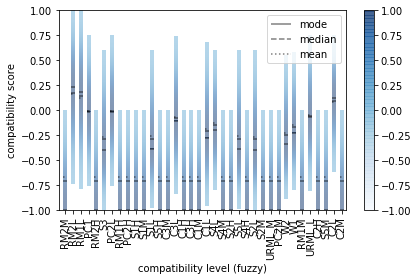

saving fig output/s_09_valp2018_bdg599_ems98.png


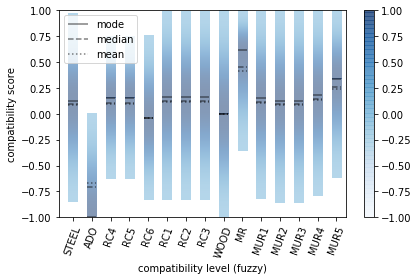

In [16]:

#compute the scores of the considered building with respect to the HAZUS class definition schema, and plot them
s_HAZUS = [scoring.compute_single_bscore_fuzzy(bdg,bt,wgs_HAZUS, bmod_schema_HAZUS, mf) for bt in bmod_schema_HAZUS.keys()]
fuzzy.plot_fnum_vec(s_HAZUS,bmod_schema_HAZUS.keys(),os.path.join(output_path,'s_09_valp2018_bdg599_hazus.png'),rot=90,loc='upper right')

#compute the scores of the considered building with respect to the EMS-98 class definition schema, and plot them
s_ems98 = [scoring.compute_single_bscore_fuzzy(bdg,bt,wgs_ems98, bmod_schema_ems98, mf) for bt in bmod_schema_ems98.keys()]
fuzzy.plot_fnum_vec(s_ems98,bmod_schema_ems98.keys(),os.path.join(output_path,'s_09_valp2018_bdg599_ems98.png'),rot=70,loc='upper left')





## Compute the exposure model according to the DESTRESS class definition schema

/Users/pittore/Documents/workspace/RIESGOS/fuzzy_schemas/lib/fuzzy_scoring/scoring.py:103: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  scores.set_value(it,'btype','OTH')


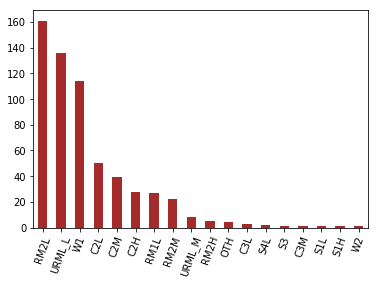

In [17]:
cl_HAZUS, cl_HAZUS_scores = scoring.compute_expo_model_fuzzy(bdg_df_val,wgs_HAZUS,
                                                   bmod_schema_HAZUS,mf,bFilterScore = True,bFilterScoreThreshold = 0.0)

cl_HAZUS['btype'].value_counts().plot(kind='bar',rot=70,color='brown')


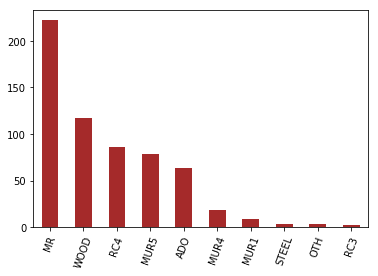

In [18]:
cl_ems98, cl_ems98_scores = scoring.compute_expo_model_fuzzy(bdg_df_val,wgs_ems98,
                                                   bmod_schema_ems98,mf,bFilterScore = True,bFilterScoreThreshold = 0.0)

cl_ems98['btype'].value_counts().plot(kind='bar',rot=70,color='brown')